In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import itertools
from scipy import stats
import pandas as pd
import seaborn as sns
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from skbio.stats.composition import ilr, clr
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from scipy.stats import chi2

from statsmodels.stats.multitest import fdrcorrection

from src.models.outliers import outlier_detection, logratio_outlier_detection, impute_zero_values
from src.visualization.plots import biplot, screeplot, loadingsplot, psuedocontrolcomparisonplot
from src.config import get_interim_dir, get_experiment_artifacts
from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, TARGET, METHOD


In [3]:
targets = ["T{}".format(t) for t in range(1,4)]

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


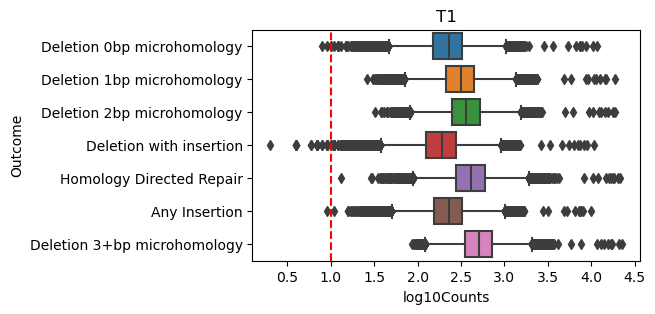

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


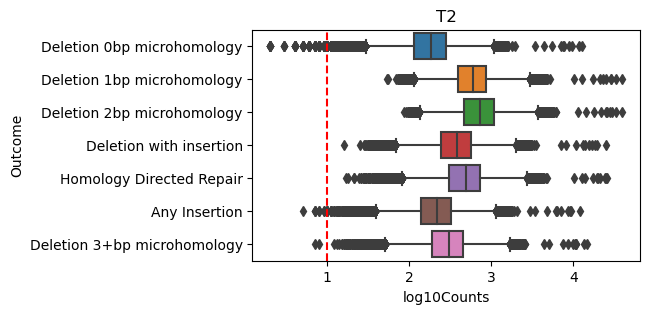

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


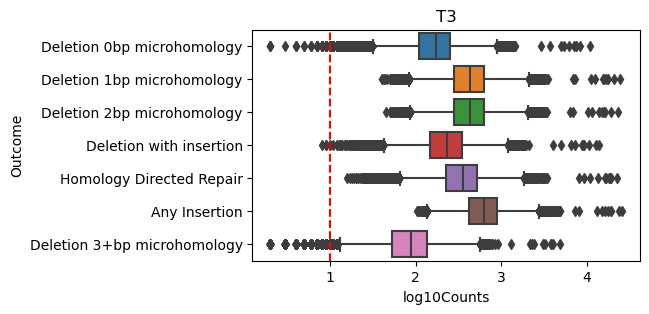

In [4]:
for target in targets: 
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.pkl".format(target, FILTER_COUNT))
    X = X.loc[:, (X != 0).any(axis=0)]
    X.columns.name = "Outcome"
    X.head()
    X = X.loc[:, (X != 0).any(axis=0)]
    plt.figure(figsize=(5, 3))
    boxplot_data = np.log10(X.stack()).reset_index().rename(columns={0: "log10Counts"})
    boxplot_data["log10median <= 1"] = boxplot_data.groupby("Outcome").median()["log10Counts"] <= 1
    sns.boxplot(data=boxplot_data, y="Outcome", x="log10Counts")
    plt.axvline(1, ls="--", color="red")
    plt.title(target)
    plt.savefig("{}/countsperfeature.{}.png".format(get_experiment_artifacts(profile_type=TARGET), target))
    plt.show()

In [5]:
X.head()

Outcome                                     Deletion 0bp microhomology  \
Target Alias Gene          Barcode                                       
T3     MB05  0610009B22Rik 0610009B22Rik-1                       205.0   
                           0610009B22Rik-2                       304.0   
                           0610009B22Rik-3                       336.0   
                           0610009B22Rik-4                       206.0   
                           0610009B22Rik-5                       227.0   

Outcome                                     Deletion 1bp microhomology  \
Target Alias Gene          Barcode                                       
T3     MB05  0610009B22Rik 0610009B22Rik-1                       510.0   
                           0610009B22Rik-2                       827.0   
                           0610009B22Rik-3                       565.0   
                           0610009B22Rik-4                       773.0   
                           0610009B22Rik-5                       424.0   

Outcome                                     Deletion 2bp microhomology  \
Target Alias Gene          Barcode                                       
T3     MB05  0610009B22Rik 0610009B22Rik-1                       477.0   
                           0610009B22Rik-2                       640.0   
                           0610009B22Rik-3                       567.0   
                           0610009B22Rik-4                       811.0   
                           0610009B22Rik-5                       696.0   

Outcome                                     Deletion with insertion  \
Target Alias Gene          Barcode                                    
T3     MB05  0610009B22Rik 0610009B22Rik-1                    318.0   
                           0610009B22Rik-2                    422.0   
                           0610009B22Rik-3                    418.0   
                           0610009B22Rik-4                    537.0   
                           0610009B22Rik-5                    306.0   

Outcome                                     Homology Directed Repair  \
Target Alias Gene          Barcode                                     
T3     MB05  0610009B22Rik 0610009B22Rik-1                     435.0   
                           0610009B22Rik-2                     521.0   
                           0610009B22Rik-3                     419.0   
                           0610009B22Rik-4                     756.0   
                           0610009B22Rik-5                     461.0   

Outcome                                     Any Insertion  \
Target Alias Gene          Barcode                          
T3     MB05  0610009B22Rik 0610009B22Rik-1          658.0   
                           0610009B22Rik-2          893.0   
                           0610009B22Rik-3          956.0   
                           0610009B22Rik-4         1029.0   
                           0610009B22Rik-5          814.0   

Outcome                                     Deletion 3+bp microhomology  
Target Alias Gene          Barcode                                       
T3     MB05  0610009B22Rik 0610009B22Rik-1                        114.0  
                           0610009B22Rik-2                         65.0  
                           0610009B22Rik-3                        121.0  
                           0610009B22Rik-4                        145.0  
                           0610009B22Rik-5                        118.0

In [426]:
X_orig = {}
X_imputed = {}
counts = {}

for alias in targets:
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    X = X.loc[:, (X != 0).any(axis=0)]
    print((X>0).sum().sum() / (X.shape[0] * X.shape[1]))

    counts[alias] = X.sum(axis=1)

    X_orig[alias] = X

    X = impute_zero_values(X, 1)
    columns = X.columns
    # X = X.div(X.sum(axis=1), axis=0)
    X = X.groupby(["Gene"]).apply(stats.gmean)
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)
    X.columns = columns

    X_imputed[alias] = X

print("Data Ready.")

0.999997701820388
0.00 of our data is zero
0.9999982148101139
0.00 of our data is zero
0.999887874390146
0.00 of our data is zero
Data Ready.


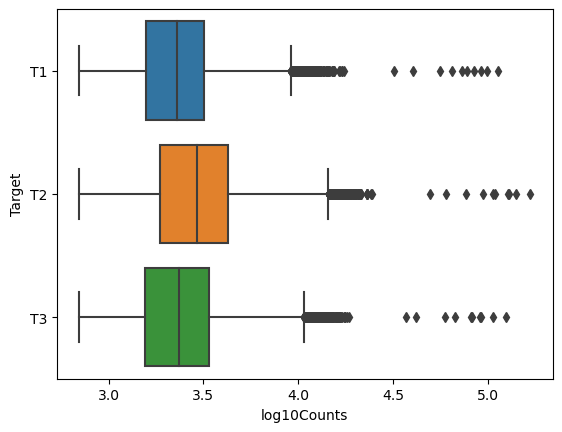

In [427]:
counts_df = pd.concat([c.reset_index().rename(columns={0: "Counts"}) for c in counts.values()])
counts_df["log10Counts"] = np.log10(counts_df["Counts"])
counts_df

sns.boxplot(data=counts_df, y="Target", x="log10Counts")
plt.savefig("{}/countsperreplicate.png".format(get_experiment_artifacts(profile_type=TARGET)))

In [428]:
df = pd.concat(X_imputed, names=["Target"]).fillna(0)
df

lumc_category         Deletion 0bp microhomology  Deletion 1bp microhomology  \
Target Gene                                                                    
T1     0610009B22Rik                    0.097901                    0.141365   
       0610010K14Rik                    0.097125                    0.137919   
       0610030E20Rik                    0.116172                    0.139147   
       0610040J01Rik                    0.102646                    0.138168   
       1110004F10Rik                    0.090606                    0.134200   
...                                          ...                         ...   
T3     Zzef1                            0.083514                    0.167624   
       Zzz3                             0.079183                    0.185125   
       a                                0.077585                    0.193105   
       ccdc198                          0.076900                    0.173864   
       mei-04                           0.076140                    0.194021   

lumc_category         Deletion 2bp microhomology  Deletion with insertion  \
Target Gene                                                                 
T1     0610009B22Rik                    0.163121                 0.082582   
       0610010K14Rik                    0.164261                 0.087338   
       0610030E20Rik                    0.160094                 0.080874   
       0610040J01Rik                    0.184187                 0.087913   
       1110004F10Rik                    0.157933                 0.073194   
...                                          ...                      ...   
T3     Zzef1                            0.173936                 0.102077   
       Zzz3                             0.190799                 0.094418   
       a                                0.171424                 0.097426   
       ccdc198                          0.198786                 0.098904   
       mei-04                           0.184247                 0.097428   

lumc_category         Homology Directed Repair  Any Insertion  \
Target Gene                                                     
T1     0610009B22Rik                  0.182600       0.102122   
       0610010K14Rik                  0.179229       0.095291   
       0610030E20Rik                  0.158632       0.090941   
       0610040J01Rik                  0.137762       0.100692   
       1110004F10Rik                  0.209681       0.087993   
...                                        ...            ...   
T3     Zzef1                          0.159660       0.265982   
       Zzz3                           0.163805       0.253684   
       a                              0.157964       0.268082   
       ccdc198                        0.167185       0.250446   
       mei-04                         0.154888       0.252256   

lumc_category         Deletion 3+bp microhomology  
Target Gene                                        
T1     0610009B22Rik                     0.230309  
       0610010K14Rik                     0.238836  
       0610030E20Rik                     0.254140  
       0610040J01Rik                     0.248632  
       1110004F10Rik                     0.246393  
...                                           ...  
T3     Zzef1                             0.047207  
       Zzz3                              0.032985  
       a                                 0.034413  
       ccdc198                           0.033916  
       mei-04                            0.041021  

[54065 rows x 7 columns]

### General Profiles Per Target Site

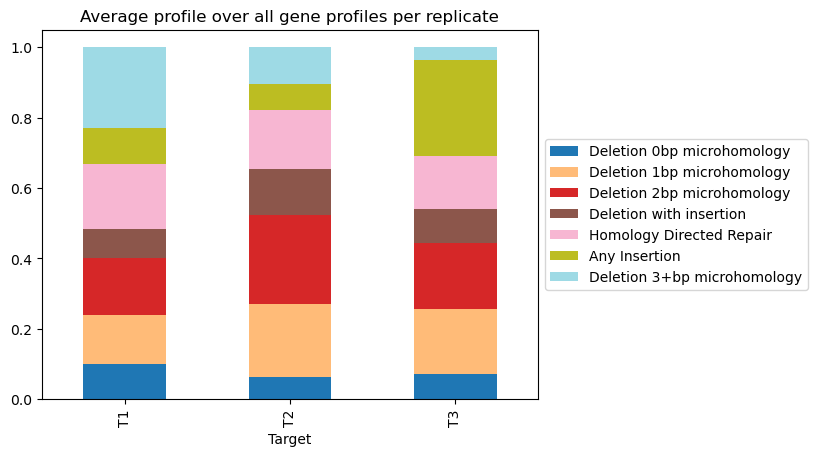

In [429]:
barplot_df = df.groupby("Target").mean().fillna(0)
f = plt.figure()
plt.title('Average profile over all gene profiles per replicate', color='black')
barplot_df.plot(kind="bar", stacked=True, ax=f.gca(), colormap="tab20")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("{}/frequencystackedbarplot.{}.png".format(get_experiment_artifacts(profile_type=TARGET), alias))
plt.show()

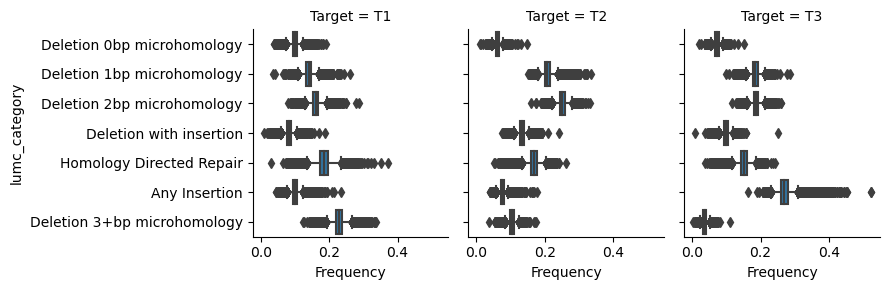

In [430]:
facetplot_df = df.stack()
facetplot_df.name = "Frequency"
facetplot_df = facetplot_df.reset_index()
g = sns.FacetGrid(facetplot_df, col="Target", height = 3, col_wrap=3, col_order=["T1", "T2", "T3"])
g.map_dataframe(sns.boxplot, y="lumc_category", x="Frequency")
plt.savefig("{}/frequencyboxplots.{}.png".format(get_experiment_artifacts(profile_type=TARGET), alias))

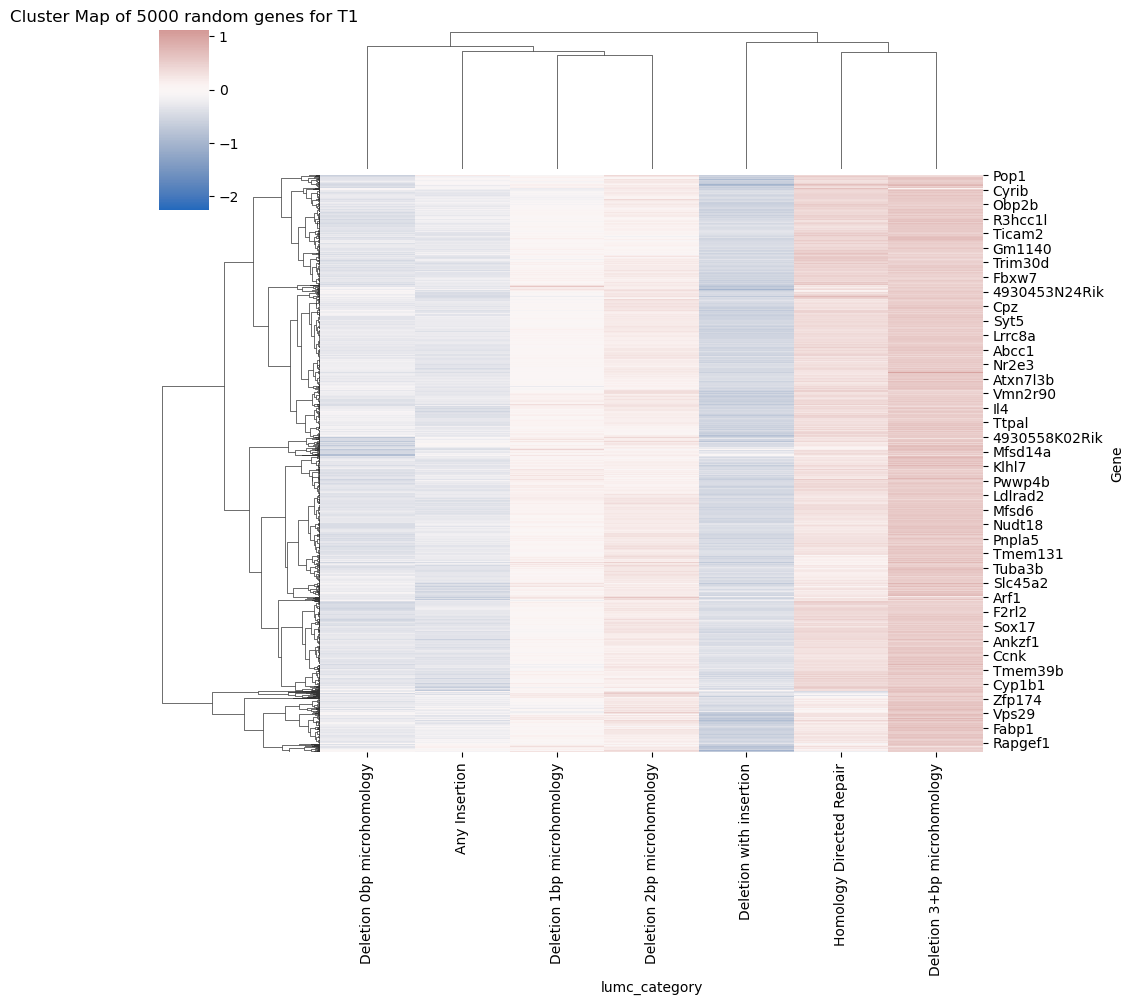

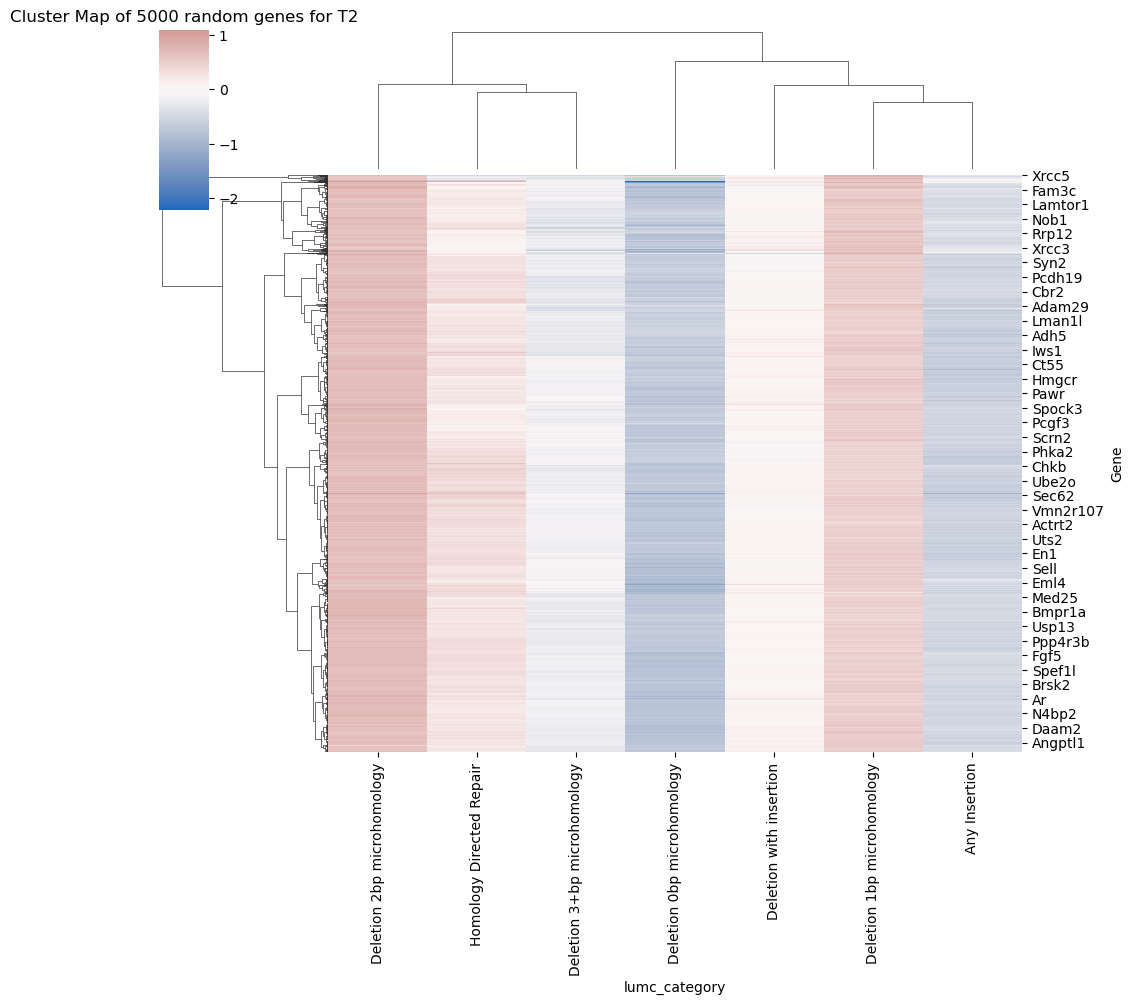

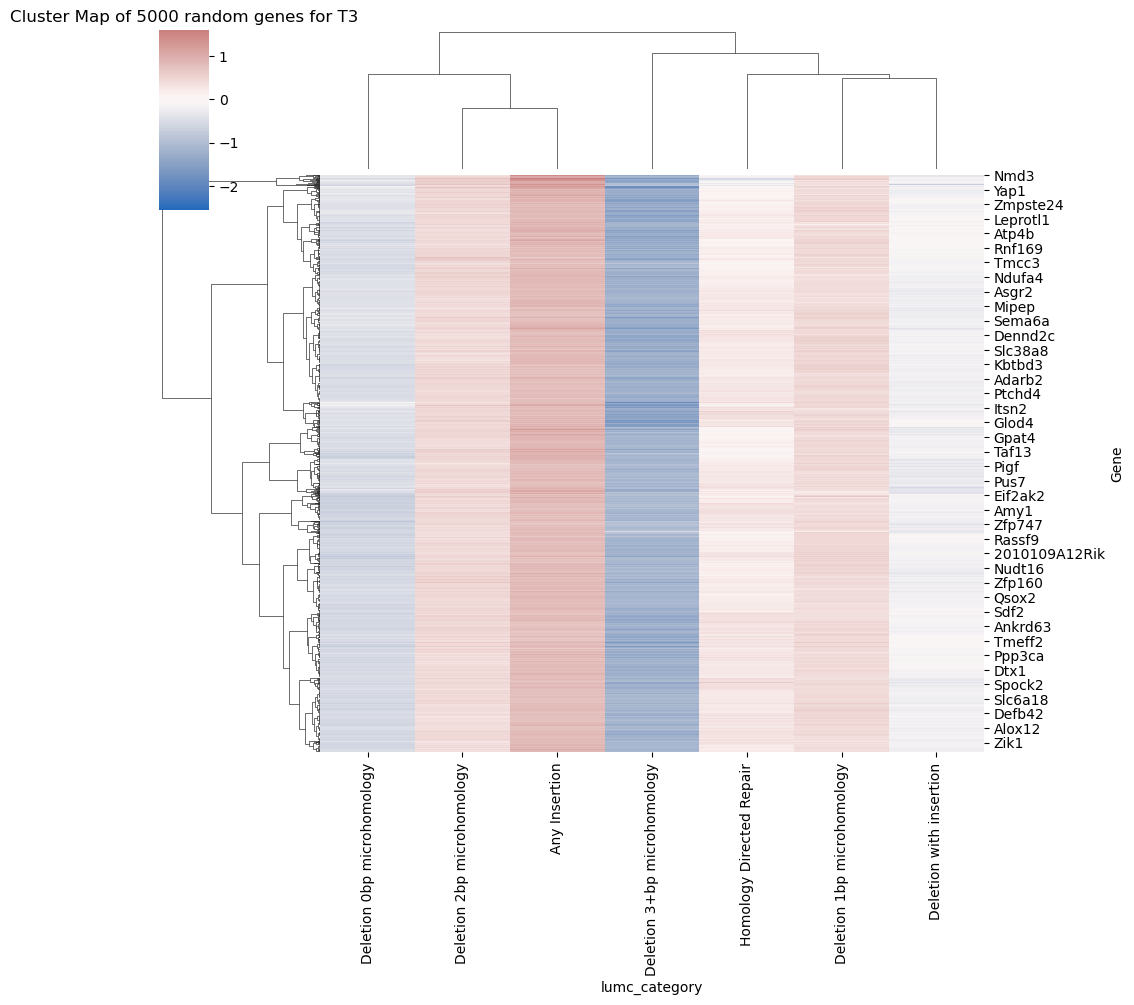

In [431]:
for alias in targets:
    clustermap_df = df.loc[alias,:].sample(5000)
    clustermap_df = clustermap_df.loc[:, (clustermap_df != 0).any(axis=0)]
    clustermap_df = pd.DataFrame(clr(clustermap_df), columns=clustermap_df.columns, index=clustermap_df.index)
    sns.clustermap(clustermap_df, metric="correlation", center=0, cmap="vlag", method="ward")
    plt.title("Cluster Map of 5000 random genes for {}".format(alias))
    plt.savefig("{}/clustermap.{}.png".format(get_experiment_artifacts(profile_type=TARGET), alias))

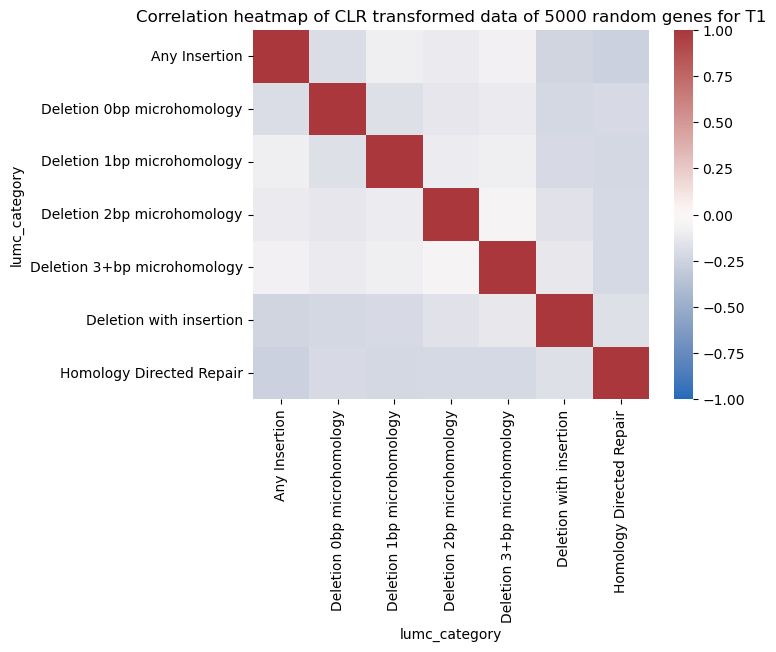

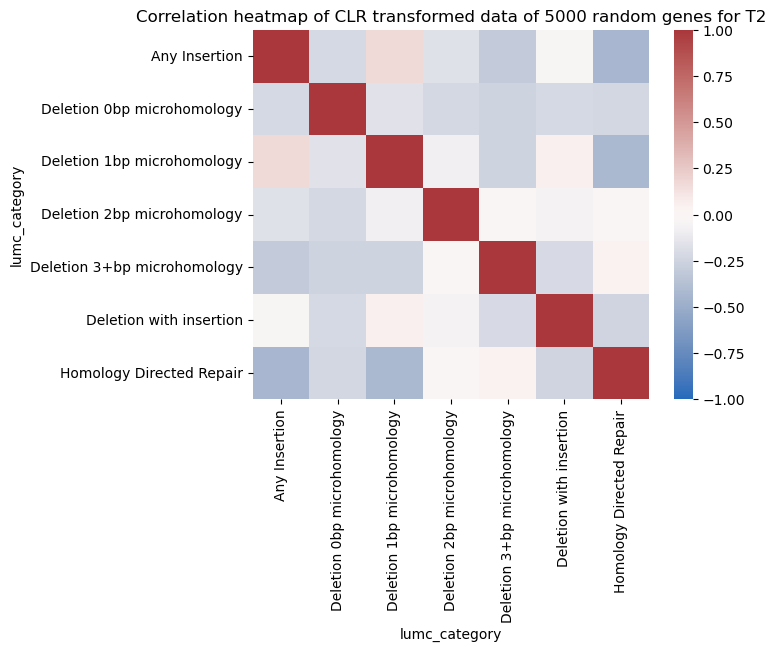

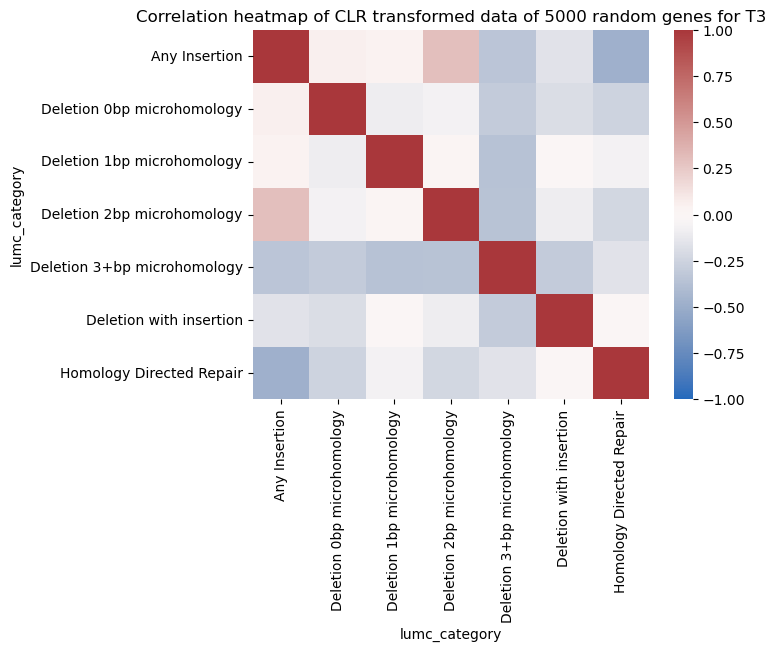

In [432]:
for alias in targets:
    clustermap_df = df.loc[alias,:].sample(5000)
    clustermap_df = clustermap_df.loc[:, (clustermap_df != 0).any(axis=0)]
    clustermap_df = pd.DataFrame(clr(clustermap_df), columns=clustermap_df.columns, index=clustermap_df.index)
    sns.heatmap(clustermap_df.T.sort_index().T.corr(),  center=0, cmap="vlag", vmax=1, vmin=-1)
    
    plt.title("Correlation heatmap of CLR transformed data of 5000 random genes for {}".format(alias))
    plt.savefig("{}/correlationheatmap.{}.png".format(get_experiment_artifacts(profile_type=TARGET), alias))
    plt.show()

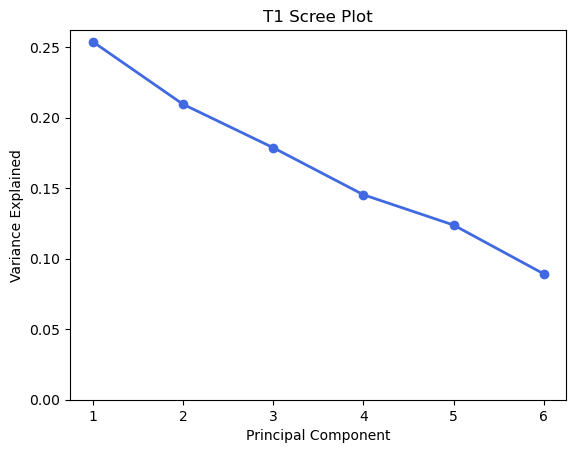

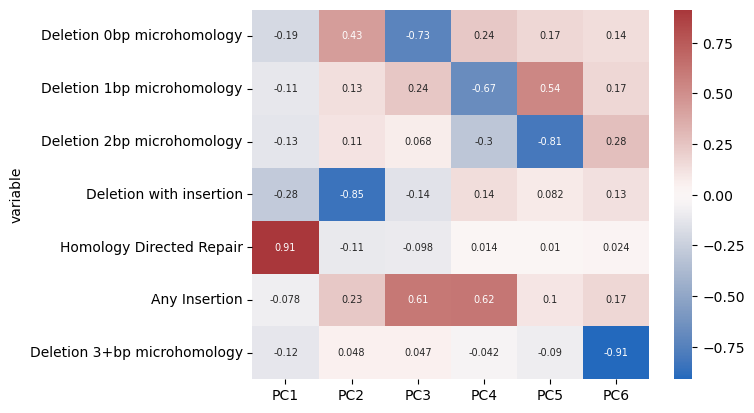

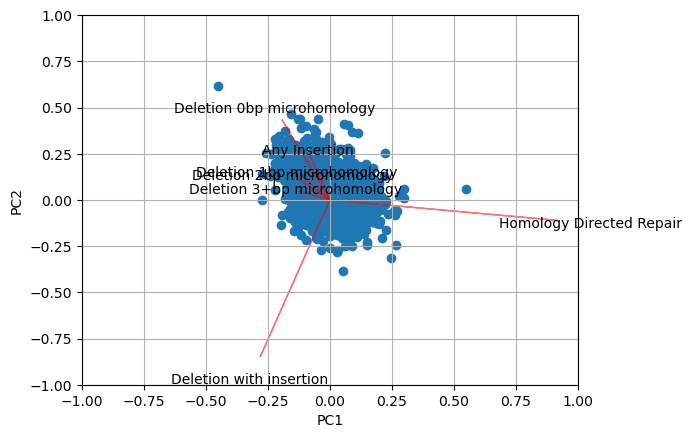

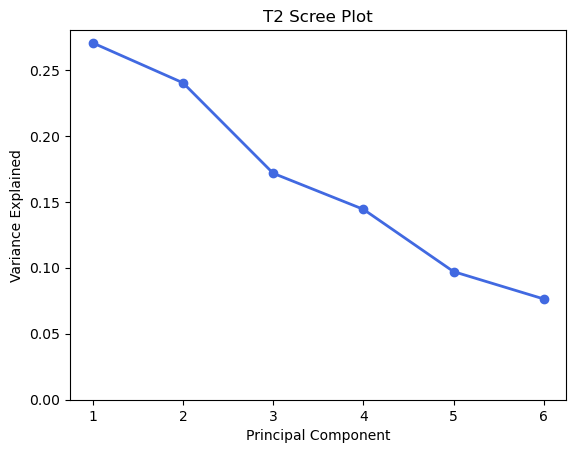

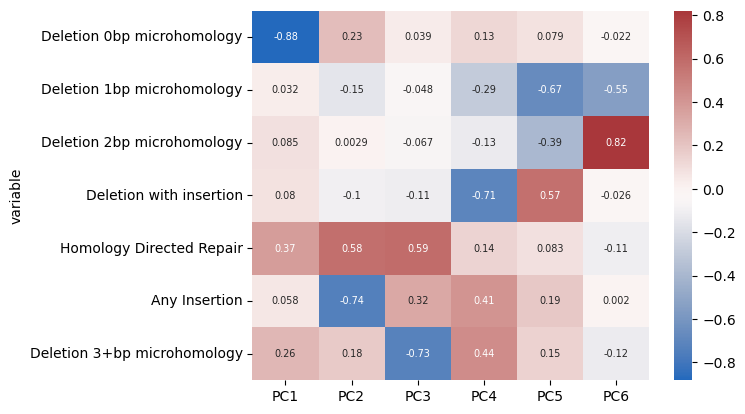

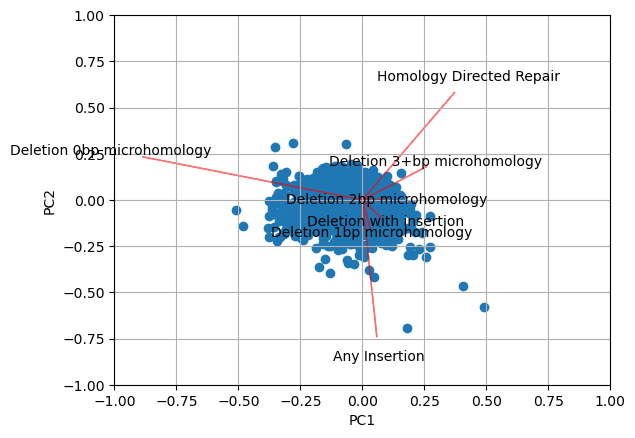

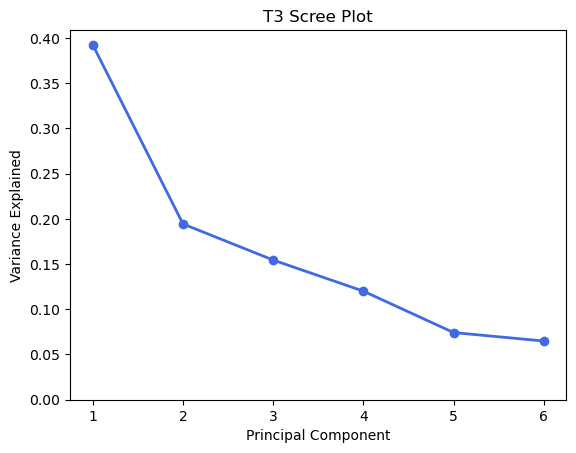

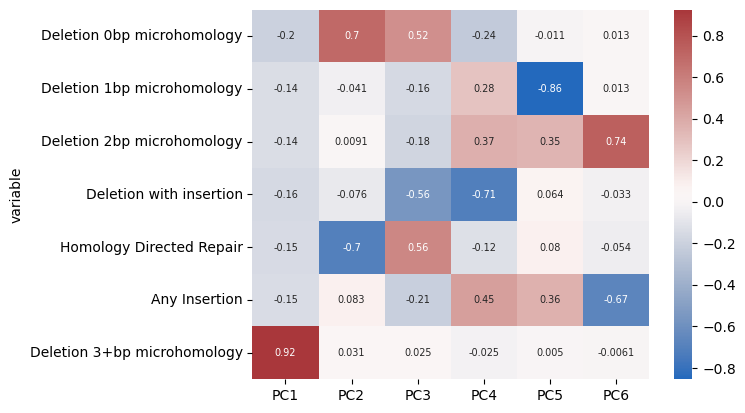

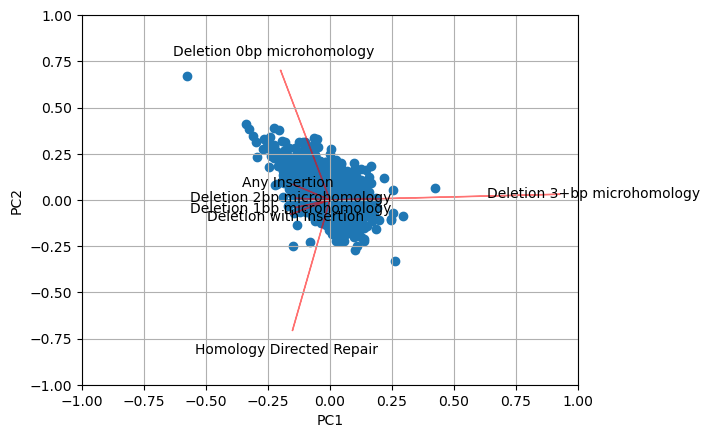

In [433]:
# Z = {}
results = {}
for alias in targets:
    # Z[alias] = ilr(X_imputed[alias].values) 
    if METHOD == "robust_cov":
        pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(X_imputed[alias], MinCovDet(random_state=0))
    elif METHOD == "pca":
        pca_scores, loadings, explained_variance_ratio, distances, pvalues = outlier_detection(X_imputed[alias], EmpiricalCovariance())
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, alias)
    plt.savefig("{}/screeplot.{}.png".format(get_experiment_artifacts(profile_type=TARGET), alias))
    plt.show()

    loadings_df, z = loadingsplot(loadings, X_imputed[alias].columns.to_list())
    plt.savefig("{}/laodingsplot.{}.png".format(get_experiment_artifacts(profile_type=TARGET), alias))
    plt.show()

    #Call the function. Use only the 2 PCs.
    pcs_to_analyse = [0,1]
    biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, labels=loadings_df.index, components=loadings_df.iloc[:,pcs_to_analyse].columns)
    plt.savefig("{}/biplot.{}.png".format(get_experiment_artifacts(profile_type=TARGET), alias))
    plt.show()

In [434]:
pvalue_dfs = [pd.DataFrame({"pvalues": results[alias][-1],
"distances": results[alias][-2]}, index=X_imputed[alias].index) for alias in targets]

# FDR correction, removed Thu 16 Feb. Can be applied later to the orignal p-values, do not rerun this code to get FDR correction. Only use final_gene_list.tsv spreadsheet
# for pvalue_df in pvalue_dfs:
#     corrected = fdrcorrection(pvalue_df["pvalues"], alpha=FDR_ALPHA)
#     pvalue_df["reject"] = corrected[0]
#     pvalue_df["pvals_corrected"] = corrected[1]

results_df = pd.concat(pvalue_dfs, axis=1, keys=targets)
results_df = results_df.join(counts_df.loc[:,["Target", "Gene", "Counts"]].groupby(['Gene', "Target"]).median().reset_index().pivot(index="Gene", columns=["Target"]).reorder_levels([1,0], axis=1)).sort_index(axis=1)
results_df.columns.names = ["Sample", "Measure"]
results_df.head()

Sample             T1                                                  T2  \
Measure        Counts  distances pvals_corrected   pvalues reject  Counts   
Gene                                                                        
0610009B22Rik  3080.5   0.156284             1.0  0.999514  False  4241.5   
0610010K14Rik  2372.0   1.331384             1.0  0.931669  False  3276.0   
0610030E20Rik  1937.5   9.023598             1.0  0.108127  False  2108.5   
0610040J01Rik  1775.5  12.094240             1.0  0.033519  False  2518.5   
1110004F10Rik  1902.5   8.805209             1.0  0.117091  False  2456.0   

Sample                                                        T3             \
Measure       distances pvals_corrected   pvalues reject  Counts  distances   
Gene                                                                          
0610009B22Rik  2.762819             1.0  0.736495  False  3506.0   6.178310   
0610010K14Rik  2.779983             1.0  0.733861  False  2782.5   2.856393   
0610030E20Rik  3.064786             1.0  0.689998  False  1997.5   3.759210   
0610040J01Rik  6.796103             1.0  0.236251  False  1909.0  14.814971   
1110004F10Rik  6.193142             1.0  0.287876  False  1788.5  11.094388   

Sample                                          
Measure       pvals_corrected   pvalues reject  
Gene                                            
0610009B22Rik             1.0  0.289253  False  
0610010K14Rik             1.0  0.722114  False  
0610030E20Rik             1.0  0.584578  False  
0610040J01Rik             1.0  0.011183  False  
1110004F10Rik             1.0  0.049540  False

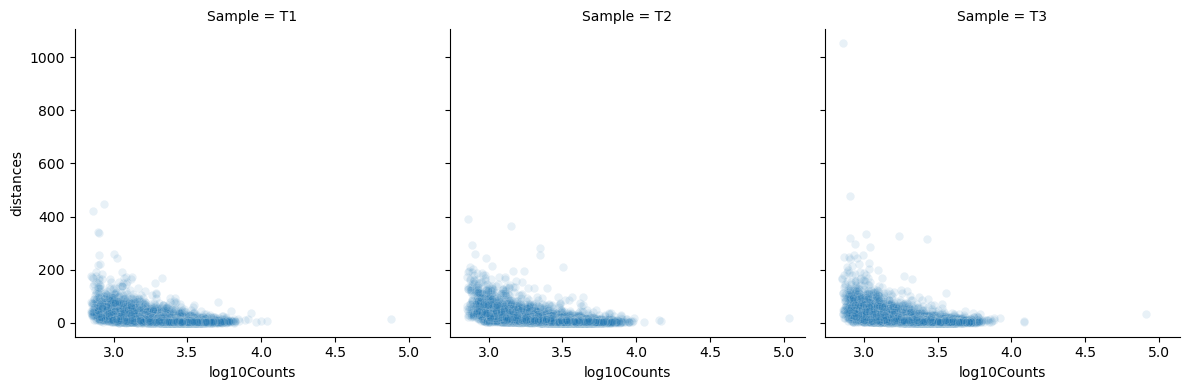

In [436]:
scatterp_df = results_df.reorder_levels([1,0], axis=1).stack().reset_index()
scatterp_df["log10Counts"] = np.log10(scatterp_df["Counts"])

g = sns.FacetGrid(data=scatterp_df, col="Sample", height = 4, col_wrap=3, col_order=["T1", "T2", "T3"])

g.map_dataframe(sns.scatterplot, x="log10Counts", y="distances", alpha=0.1)
plt.savefig("{}/countsvsdistance.png".format(get_experiment_artifacts(profile_type=TARGET)))

In [437]:
results_df.to_pickle(get_experiment_artifacts(profile_type=TARGET) + "outlier_results.pkl")
pkl.dump(X_imputed, open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=TARGET)), "wb"))